# Project: Mexico City Urban Bicycle Network Analysis

### Darío Díaz Cuevas

This project aims to analyze a public data base from Mexico City's public bike sharing system (ECOBICI), obtained from the [official website](https://www.ecobici.cdmx.gob.mx/en) (available both in Spanish and English).


As described on the website, ECOBICI started operating in February 2010 with 84 bike stations and 1,200 bikes. In only 6 years the system has grown 400% due to users demand. There are currently 480 bike stations, more than 6,000 bikes and more than 100,000 users benefit from this service from Monday to Sunday inside a 35 km2 area.

The public bike sharing system ECOBICI has been adopted as an efficient transportation alternative to move around Mexico City, not only because it complements the massive transportation network, but also because of the health, environmental, and time-saving benefits that contribute to a better quality of life.

A map of the current ECOBICI coverage within Mexico City is shown below for ilustration purposes.

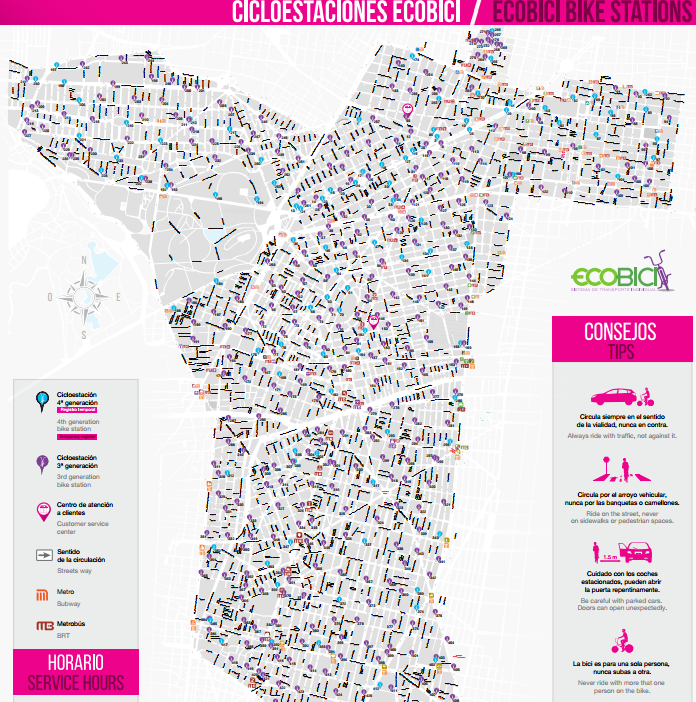

In [1]:
from IPython.display import Image
Image(filename='ECOBICI_map.png') 

### Usage information

ECOBICI allows registered users to take a bike at any bike station and return it to the bike station closest to their destination, unlimited trips of a maximum duration of 45 minutes are permitted. Anyone who wants to access the ECOBICI system can pay a subscription for one year, one week, three days or one day.

In order to withdraw and return a bike, an ECOBICI card must be scanned at the bike station. The hours of service are Mon-Sun, from 5:00 am to 12:30 am.

### Research questions

The purpose of this final proyect is to analyze the available data in order to attempt to give an answer to the following questions:

- Is there a difference in the duration of bike trips made by male and female users?
- Can the duration of a bike trip be estimated by the user gender and age, as well as the date, time, and start/end points?
- Can different types of user behaviours be identified using the available data?

### Data sources, loading, cleaning, and exploratory analysis

ECOBICI open data consists of a set of historical files of usages ranging from February 2010 to present date, available for download as monthly reports in `csv` format. There is also an `API` where a complete list of bike stations and live bike availability data can be queried from.

Due to the Covid-19 pandemic, the total number of ECOBICI rides as well as the typical user behaviour have dramatically changed since early 2020. For this reason, only data from mid-2019 was considered in the analysis. Specifically, usage data from May 2019 was employed*. 

Bikes and bike stations are uniquely labeled by an integer number. It is worth mentioning that bike station numeration and location are not related. Hence, stations with similar numbers are not necessarily geographically close to each other.  

The structure and data types of the May 2019 usage data is shown in the following cells of code. 

*Variable names have been translated to English. Dates follow a DD/MM/YYYY format.

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [1]:
#read data from csv file
df_usage = pd.read_csv("2019-05.csv")
#rename columns in english
eng_names = ["user_gender","user_age","bike","departure_station","departure_date","departure_time",\
             "arrival_station","arrival_date","arrival_time"]
d = {df_usage.columns[i] : eng_names[i] for i in range(len(eng_names))}
df_usage.rename(columns=d,inplace=True)
#show first 5 observations
df_usage.head()

,user_gender,user_age,bike,departure_station,departure_date,departure_time,arrival_station,arrival_date,arrival_time
0,M,25,1427,372,01/05/2019,00:00:04,397,01/05/2019,00:05:18
1,M,26,8431,202,01/05/2019,00:00:26,318,01/05/2019,00:32:24
2,M,28,10212,340,01/05/2019,00:00:49,394,01/05/2019,00:11:31
3,F,23,12098,290,01/05/2019,00:00:51,292,01/05/2019,00:05:30
4,M,33,11352,290,01/05/2019,00:01:03,292,01/05/2019,00:05:31


In [3]:
#print table dimensions
print("Usage data table contains",df_usage.shape[0],"instances, and",df_usage.shape[1],"variables.")

Usage data table contains 750910 instances, and 9 variables.


In [4]:
#information and data types
print("Variable list and types:\n")
df_usage.info()

Variable list and types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750910 entries, 0 to 750909
Data columns (total 9 columns):
user_gender          750910 non-null object
user_age             750910 non-null int64
bike                 750910 non-null int64
departure_station    750910 non-null int64
departure_date       750910 non-null object
departure_time       750910 non-null object
arrival_station      750910 non-null int64
arrival_date         750910 non-null object
arrival_time         750910 non-null object
dtypes: int64(4), object(5)
memory usage: 51.6+ MB


The data table is inspected to detect possible missing values, which is fortunately not the case. For this reason, no row/column deletion nor data imputation techniques need to be applied.

In [5]:
#missing value search
df_usage.isnull().any()

user_gender          False
user_age             False
bike                 False
departure_station    False
departure_date       False
departure_time       False
arrival_station      False
arrival_date         False
arrival_time         False
dtype: bool

Dates and times are combined into a new date-time formatted variables containing the complete date and time information for departures and arrivals. 

Using these new variables, the total duration (in minutes) of bike trips is computed.

In [6]:
#conversion to date and time
df_usage["departure_datetime"] = pd.to_datetime(df_usage["departure_date"] + " " + df_usage["departure_time"],dayfirst = True)
df_usage["arrival_datetime"] = pd.to_datetime(df_usage["arrival_date"] + " " + df_usage["arrival_time"],dayfirst = True)

In [7]:
#trip duration in minutes
df_usage["travel_time"] = (df_usage["arrival_datetime"] - df_usage["departure_datetime"]).dt.total_seconds()/60

Upon inspection of the newly defined travel time field, some irregularities can be noted:

For instance, the minimum trip duration is negative, which is clearly a system error. Similarly the maximum value is roughly equal to 2550 hours, which is either an error, or that observation might correspond to a user who failed to return the bike to a station on time. Since bike trip should be at most 45 minutes long, one would expect the standard deviation to be smaller than its rather high value, which is thus a consequence of outliers.

In [8]:
#summary statistics
df_usage["travel_time"].describe()

count    750910.000000
mean         14.960994
std         221.671455
min       -1429.066667
25%           6.733333
50%          10.883333
75%          17.566667
max      153132.816667
Name: travel_time, dtype: float64

Trips of zero-minute duration can be attributed to users who fail to undock the bike from its anchor point in the station, as well as system errors. For that reason, it makes sense to keep only instances where the travel time is strictly positive. There exist cases where users take a bike and immediately return it to the same station, as well as very short trips made to contiguous stations. However, defining a cut-off minimum travel time would be rather arbitrary. Hence, trips with positive durations are retained.

In [9]:
#filter negative durations
df_usage = df_usage[df_usage["travel_time"]>0]

As mentioned before, bike trips can be at most 45 minutes long. Exceeded travel times might cause users to have their membership temporarily suspended, or even terminated in extreme cases. By looking at trips longer than 45 minutes, it can be seen that observations corresponding to large travel times are numerous.

After sorting in descending order, extremely large times are observed.

In [10]:
#filter long trips and sorting 
df_usage[["travel_time"]][df_usage["travel_time"]>45].sort_values("travel_time",ascending = False)

,travel_time
584701,153132.816667
325373,96387.983333
242703,52802.016667
70163,14637.133333
571992,11703.916667
...,...
33316,45.016667
254227,45.016667
373378,45.016667
257677,45.016667


By looking at the 99% percentile of the duration of all trips, it can be observed that despite the existence of multiple users who made very long trips, 99% of all trips are under one hour of duration. Thus, to avoid completely eliminating moderately long trips, outlying instances correponding to durations greater than 80 minutes are dropped.

In [11]:
#99% percentile computation
np.percentile(df_usage[["travel_time"]].sort_values("travel_time",ascending = False).values,99)

48.36666666666667

In [12]:
#filter out trips longer than 80 minutes
df_usage = df_usage[df_usage["travel_time"]<=80]

A histogram for travel time reveals a skewed distribution heavily biased towards shorter trips. Since the number of observations is very large, a finer grid of bins can be used to better appreaciate the shape of the distribution.

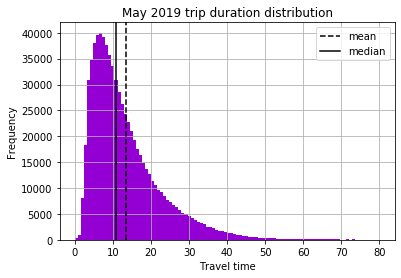

In [13]:
#duration distribution visualization
fig = plt.figure(figsize=(6,4))
plt.hist(df_usage.travel_time.values,color="darkviolet",bins=100)
plt.xlabel("Travel time")
plt.ylabel("Frequency")
plt.title("May 2019 trip duration distribution")
line_mean = plt.axvline(x=df_usage.travel_time.values.mean(),color="black",linestyle="--")
line_median = plt.axvline(x=np.median(df_usage.travel_time.values),color="black",linestyle="-")
plt.legend(handles=[line_mean,line_median],labels=["mean","median"])
plt.grid(True)
plt.savefig("duration_hist.png")
plt.show()

Once rows have been filtered by detecting errors and outliers corresponding to trip durations, other variables can be explored.

The following histograms reveal that the number of bike trips made my male users is almost three times the number of trips made by female users. Also shown is the fact that the age distribution of users is positively skewed, meaning that most trips are made by rather young users. The majority of trips is made by people aged around 30. It is also interesting to note that people in their early 20's and younger, tend to use ECOBICI way less than people in older age groups.

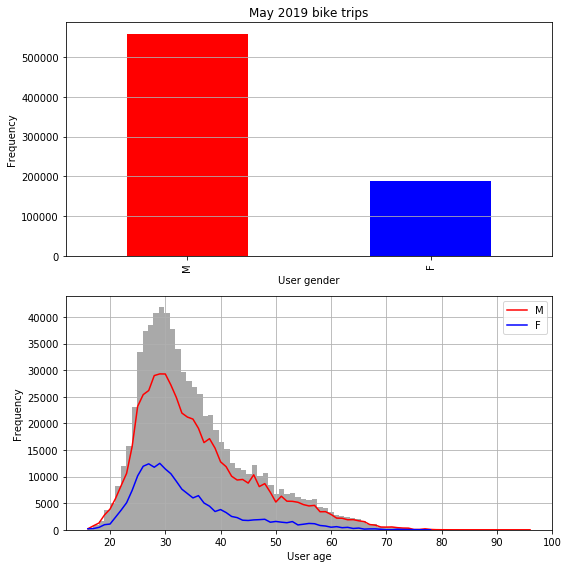

In [14]:
#gender and age distribution visualization
fig , axs = plt.subplots(figsize=(8,8),ncols=1,nrows=2)
df_usage["user_gender"].value_counts().plot(kind='bar',ax=axs[0],color=["red","blue"])
axs[0].set_xlabel("User gender")
axs[0].set_ylabel("Frequency")
axs[0].grid(axis="y")
axs[0].set_title("May 2019 bike trips")
axs[1].hist(df_usage.user_age,bins=81,color="darkgray")
axs[1].set_xlabel("User age")
axs[1].set_ylabel("Frequency")
axs[1].plot(df_usage["user_age"][df_usage["user_gender"]=="M"].value_counts().sort_index().index,df_usage["user_age"][df_usage["user_gender"]=="M"].value_counts().sort_index().values,color="red",label="M")
axs[1].plot(df_usage["user_age"][df_usage["user_gender"]=="F"].value_counts().sort_index().index,df_usage["user_age"][df_usage["user_gender"]=="F"].value_counts().sort_index().values,color="blue",label="F")
axs[1].legend()#title="Usage by gender")
axs[1].grid(True)
plt.tight_layout()
plt.savefig("gender_age_hists")
plt.show()

Another interesting insight can be obtained by looking at the distribution of bike trips across time and date. In order to visualize this distribution, the departure hours, and well as the day of the week (Monday=0 to Sunday=6) and day of the month are considered. Afterwards, a heatmap is used to observe the two-dimensional distribution of trips.

In [15]:
#day of the week, day of the month, and hour of the day are extracted from departure date-time variable
df_usage["departure_weekday"] = df_usage["departure_datetime"].dt.dayofweek
df_usage["departure_day"] = df_usage["departure_datetime"].dt.day
df_usage["departure_hour"] = df_usage["departure_datetime"].dt.hour

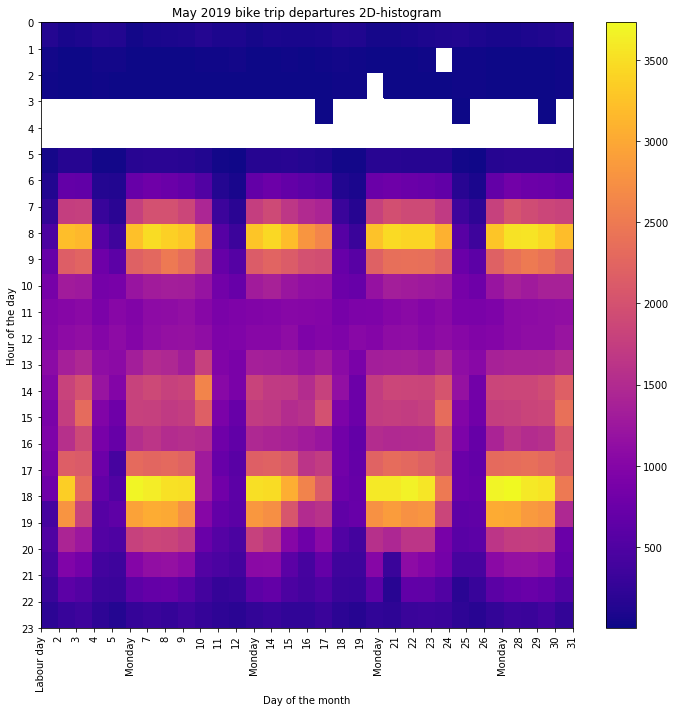

In [16]:
#2d histogram
fig = plt.figure(figsize=(10,10))
plt.hist2d(df_usage["departure_day"],df_usage["departure_hour"],bins=[31,24],cmin=1,cmap="plasma")
plt.xticks(range(1,32),rotation="vertical",labels=["Labour day"]+[str(i) if not (i+1)%7==0 else "Monday" for i in range(2,32)])
plt.yticks(range(0,24))
plt.gca().invert_yaxis()
plt.xlabel("Day of the month")
plt.ylabel("Hour of the day")
plt.title("May 2019 bike trip departures 2D-histogram")
plt.colorbar()
plt.savefig("heatmap.png")
plt.tight_layout()
plt.show()

The previous plot shows that the number of daily trips has a seasonal component on both day of the month and hour of the day. The peak times coincide with both weekdays and workday start and end hours. This suggests that users of the ECOBICI bike network utilize it as a method of transportation as part of their daily commute to work, make up a large portion of the total number of trips. Notice how Labour day (celebrated on May 1st) seems to disrupt the bike usage pattern. These findings agree with the age histograms which show it is mostly people in working age who ride ECOBICI bikes.

Mexico City is a large urban area with a massive subway network, and plenty of bus, BRT, and train routes. However, the city is overpopulated, has serious traffic problems, and numerous people come to work from neighboring cities and towns, which contributes to further saturating the transportation services and the city's traffic. ECOBICI might be actually helping thousands of employees to travel between work and home without needing to spend longer times frustrated in traffic. Besides allowing people to have a more enjoyable and healthy commute, ECOBICI might also be contributing to lower pollution emissions in Mexico City by offering a green transportation method.

In addition to bike usage data, a list of ECOBICI bike stations was obtained through ECOBICI's `API`. The following cell of code is a modified version of a class publicly available [here](https://github.com/dominoFire/ecobici-python/blob/master/ecobici.py), and it performs the requiered queries:

In [2]:
#import required libraries
import requests
import json

#personal id and secret keys
#removed from submitted jupyter notebook for security reasons
client_id = 
client_secret =
#urls
base_url = "https://pubsbapi-latam.smartbike.com"
url_access = "{}/oauth/v2/token?client_id={}&client_secret={}&grant_type=client_credentials".format(base_url, client_id,client_secret)

#request access token
r_access = requests.get(url_access)
access_token = r_access.json()['access_token']

#url and request for station list
url = "{}/api/v1/stations.json?access_token={}".format(base_url, access_token)
r_stations = requests.get(url)

#save to pandas dataframe
stations = r_stations.json()
df_stations = pd.DataFrame(stations["stations"])

C:\Users\dacuevasdiaz\AppData\Local\Continuum\anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


The station list can be extracted in `json` format and then saved to a `pandas` dataframe. 

Inspecting the table shows that each of the 480 bike stations appears only once in the table, accompanied by the corresponding information such as ID, name, address, geographical coordinates, etc.

In [3]:
df_stations.head()

,id,name,address,addressNumber,zipCode,districtCode,districtName,altitude,nearbyStations,location,stationType
0,124,124 CLAUDIO BERNARD-DR. LICEAGA,124 - Claudio Bernard-Dr. Liceaga,S/N,06500,1,Ampliación Granada,None,"[119, 123, 133]","{'lat': 19.422392, 'lon': -99.150358}",BIKE
1,159,159 HUATABAMPO-EJE 1 PTE. AV. CUAUHTÉMOC,159 - Huatabampo-Eje 1 Pte. Av. Cuauhtémoc,S/N,06760,1,Ampliación Granada,None,"[155, 158, 163]","{'lat': 19.407517, 'lon': -99.155373}",BIKE
2,241,E241 EJERCITO NAL-JUAN VAZQUEZ DE LA MELLA,241 - Ejercito Nacional-Juan Vazquez de la Mella,S/N,11520,1,Ampliación Granada,None,"[222, 460]","{'lat': 19.43862, 'lon': -99.20758}",ELECTRIC_BIKE
3,243,243 MIGUEL DE CERVANTES SAAVEDRA-LAGO FILT,243 - Miguel de Cervantes Saavedra-Lago Filt,S/N,11510,1,Ampliación Granada,None,"[199, 242, 244]","{'lat': 19.440839, 'lon': -99.196712}",BIKE
4,350,350 JOSE CLEMENTE OROZCO-CORREGGIO,350 - Jose Clemente Orozco-Correggio,S/N,3710,1,Ampliación Granada,None,"[349, 352]","{'lat': 19.384062, 'lon': -99.181482}",BIKE


In [4]:
#no duplicated ids
df_stations["id"].duplicated().any()

False

In [5]:
#print table dimensions
print("Bike station table contains",df_stations.shape[0],"instances, and",df_stations.shape[1],"variables.")

Bike station table contains 480 instances, and 11 variables.


In [6]:
#variables and types
print("Variable list and type:\n")
df_stations.info()

Variable list and type:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 11 columns):
id                480 non-null int64
name              480 non-null object
address           480 non-null object
addressNumber     480 non-null object
zipCode           479 non-null object
districtCode      480 non-null object
districtName      480 non-null object
altitude          0 non-null object
nearbyStations    480 non-null object
location          480 non-null object
stationType       480 non-null object
dtypes: int64(1), object(10)
memory usage: 41.4+ KB


This table contains missing values in the zip code and altitude fields. However, these variables will not be necessary and they can be deleted.

In [7]:
#detection of missing values
df_stations.isnull().any()

id                False
name              False
address           False
addressNumber     False
zipCode            True
districtCode      False
districtName      False
altitude           True
nearbyStations    False
location          False
stationType       False
dtype: bool

In [8]:
#deletion of columns with missing values
del df_stations["altitude"]
del df_stations["zipCode"]

The location of each station is given by the latitude and longitude. These values are contained in a column as dictionaries, from which they can be extracted to define separate variables.

Since these variables will be used as predictors for the trip duration, they will be standardized by substracting their mean and dividing by their standard deviation.

In [9]:
#extract latitude and longitude
df_stations["latitude"] = pd.Series([d["lat"] for d in list(df_stations["location"])])
df_stations["longitude"] = pd.Series([d["lon"] for d in list(df_stations["location"])])

#standardize variables
df_stations["latitude"] = (df_stations["latitude"]-df_stations["latitude"].mean())/df_stations["latitude"].std()
df_stations["longitude"] = (df_stations["longitude"]-df_stations["longitude"].mean())/df_stations["longitude"].std()

By combining the usage and station tables, information about the departure and arrival station location, as well as the bike type can be assigned to each trip made by users.

In [15]:
#merge data sets
df_usage = pd.merge(df_usage,df_stations[["id","latitude","longitude","stationType"]],how="left",left_on="departure_station",right_on="id").rename(columns={"latitude":"departure_latitude","longitude":"departure_longitude","stationType":"bike_type"})
del df_usage["id"]
df_usage = pd.merge(df_usage,df_stations[["id","latitude","longitude"]],how="left",left_on="arrival_station",right_on="id").rename(columns={"latitude":"arrival_latitude","longitude":"arrival_longitude"})
del df_usage["id"]

11 rows of the merged table have missing observations in the arrival location variable. This occurs because the stations 1002 and 3000 do not appear in the official list of 480 bike stations. Since this number of missing values is very small, these rows are dropped.

In [16]:
df_usage[df_usage[["arrival_latitude","arrival_longitude"]].isna().any(axis=1)]

,user_gender,user_age,bike,departure_station,departure_date,departure_time,arrival_station,arrival_date,arrival_time,departure_latitude,departure_longitude,bike_type,arrival_latitude,arrival_longitude
53709,M,24,8198,116,03/05/2019,13:17:38,1002,03/05/2019,13:37:28,0.791354,0.902953,BIKE,NaN,NaN
70163,M,23,3865,186,23/04/2019,09:40:19,1002,03/05/2019,13:37:27,0.113686,-1.110531,BIKE,NaN,NaN
72950,M,39,8809,10,04/05/2019,10:49:28,1002,04/05/2019,21:21:19,0.968835,1.022226,"BIKE,TPV",NaN,NaN
82642,M,33,10866,126,03/05/2019,18:06:56,1002,04/05/2019,14:55:10,0.517231,0.555618,BIKE,NaN,NaN
101981,F,24,12195,441,06/05/2019,10:04:43,3000,06/05/2019,10:10:26,-1.982613,0.215170,BIKE,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722241,M,27,12338,17,29/05/2019,18:59:30,1002,30/05/2019,06:07:04,0.730610,0.240566,"BIKE,TPV",NaN,NaN
730439,F,61,9656,64,31/05/2019,09:56:00,1002,31/05/2019,16:00:49,0.132020,0.249348,BIKE,NaN,NaN
750846,M,27,4330,154,30/05/2019,10:17:36,1002,31/05/2019,04:41:30,-0.121514,0.187689,"BIKE,TPV",NaN,NaN
750848,M,38,9459,26,30/05/2019,16:02:16,1002,31/05/2019,01:04:01,0.942802,1.023869,"BIKE,TPV",NaN,NaN


In [17]:
df_stations[(df_stations["id"].isin([1002,3000]))]

,id,name,address,addressNumber,districtCode,districtName,nearbyStations,location,stationType,latitude,longitude


In [28]:
df_usage.dropna(axis=0,inplace=True)
df_usage.reset_index(drop=True,inplace=True)

Lastly, data type of departure and arrival station number, user gender, departure weekday, and and bike type, is transformed to categorical in order to feed these variables into the predictive model.

Additionally, the sine and cosine transformations
$$
sin(2\pi x / \text{period}), \quad cos(2\pi x / \text{period})
$$
are applied to the departure hour variable (period=24) to take into account its cyclical nature and include it in the model.

In [29]:
#conversion to categorical type
for s in ["user_gender","departure_station","arrival_station","departure_weekday","bike_type"]:
    df_usage[s] = df_usage[s].astype("category")
    
#cyclical variables
period = 24
df_usage["departure_hour_sin"] = np.sin(2*np.pi*df_usage["departure_hour"]/period)
df_usage["departure_hour_cos"] = np.cos(2*np.pi*df_usage["departure_hour"]/period)

After the cleaning and data integration process, the usage data table structure now contains the neccesary variables and types, and is displayed in the following cell:

In [30]:
df_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748237 entries, 0 to 748236
Data columns (total 22 columns):
user_gender            748237 non-null category
user_age               748237 non-null int64
bike                   748237 non-null int64
departure_station      748237 non-null category
departure_date         748237 non-null object
departure_time         748237 non-null object
arrival_station        748237 non-null category
arrival_date           748237 non-null object
arrival_time           748237 non-null object
departure_datetime     748237 non-null datetime64[ns]
arrival_datetime       748237 non-null datetime64[ns]
travel_time            748237 non-null float64
departure_weekday      748237 non-null category
departure_day          748237 non-null int64
departure_hour         748237 non-null int64
departure_latitude     748237 non-null float64
departure_longitude    748237 non-null float64
bike_type              748237 non-null category
arrival_latitude       748237 non-nu

### Models and findings:

In order to address the first research question, summary statistics are first obtained, grouping observations by user gender.

In [31]:
#summary statistics by gender
df_usage.groupby("user_gender")[["travel_time"]].describe()

travel_time                                                 \
                  count       mean       std       min  25%        50%   
user_gender                                                              
F              188769.0  13.813889  9.394245  0.016667  7.1  11.300000   
M              559468.0  13.277851  9.324944  0.016667  6.6  10.683333   

                                   
                   75%        max  
user_gender                        
F            17.916667  79.816667  
M            17.300000  79.983333

According to the mean and quartiles from the previous summary, female users seem to be making slighly longer bike trips on average. In order to determine whether the mean travel time of female and male users differ in a statistically significant way, a two-sample statistical test is performed. 

For this purpose, the Welch's t-test is employed. The test statistic is the following:
$$
t = \dfrac{\bar{X}_M-\bar{X}_F}{\sqrt{\dfrac{S_M^2}{N_M} + \dfrac{S_F^2}{N_F} }}
$$

where $\bar{X}_M$ and $\bar{X}_F$ represent the male and female mean durations respextively, and similarly $S_M^2$ and $S_F^2$ denote the sample variances for each gender, while $N_M$ and $N_F$ are the sample sizes.

This test assumes that the trip duration is normally distributed, as well as independence between users. Contrary to the well-known Student's t-test, equal population variances are not assumed. Given that these assumptions are satisfied, the test statistic is approximately from the t-distribution.

The hypothesis being tested is $\mu_M = \mu_F$ vs. $\mu_M \neq \mu_F$ (two-sided test), where $\mu_M$ and $\mu_F$ denotes the mean travel time for male and female users respectively.

Before running the test, a transformation needs to be applied to the travel time variable in order to bring its highly skewed distribution shown above, to a distribution close to Gaussian.

The proposed transformation is the natural logarithm, which is often used to eliminate skew. The next plot compares the distribution of trip duration with and without the logartimic transformation. Note how the transformed data has a more symmetrical distribution that looks more like a Gaussian.

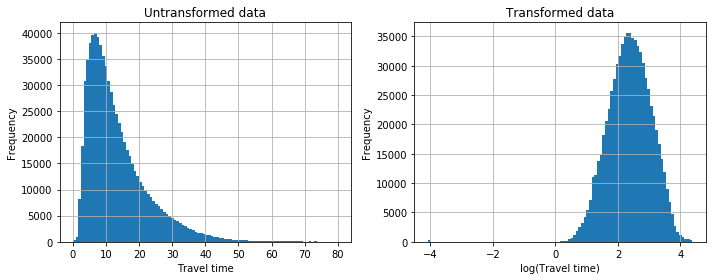

In [32]:
fig, axs = plt.subplots(figsize=(10,4),nrows=1,ncols=2)
axs[0].hist(df_usage["travel_time"],bins=100)
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Travel time")
axs[0].set_title("Untransformed data")
axs[0].grid(True)
axs[1].hist(np.log(df_usage["travel_time"]),bins=100)
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("log(Travel time)")
axs[1].set_title("Transformed data")
axs[1].grid(True)
plt.savefig("log_duration.png")
plt.tight_layout()
plt.show()

The Welch's t-test is now applied to the transfomed data. The obtained p-value is less than 0.05, which means the equal mean hypothesis is rejected a the 0.05 significance level.

The test statistic has a negative value and its p-value divided by two is still less than 0.05. This implies that the one sided test for the hypothesis $\mu_M >= \mu_F$ would be rejected in favor of $\mu_M < \mu_F$ at the 0.05 significance level.

These test allow us to conclude that there is statistically significant evidence to support the idea that female users tend to make larger bike trips than male users.

In [33]:
#import t test for independent samples from scipy
from scipy.stats import ttest_ind

#run the test with the durations for male and female users
ttest_ind(a=np.log(df_usage["travel_time"][df_usage["user_gender"]=="M"].values),b=np.log(df_usage["travel_time"][df_usage["user_gender"]=="F"].values),equal_var=False)

Ttest_indResult(statistic=-29.833493218651533, pvalue=2.604770940977746e-195)

The next model to be applied involves predicting the duration of bike trips based on user and start/end point information. Travel time plays the role of the response variable, while the variables to be included as predictors in the model are the following: User gender, user age, departure station, arrival station, departure day of the week, departure day of the month, departure hour (cosine/sine transformations), bike type, departure latitude/longitude (standardized), and arrival latitude/longitude (standardized).  

In [34]:
#define response vector y and predictor matrix X
y = df_usage["travel_time"]
X = df_usage[["user_gender","user_age","bike_type","departure_weekday","departure_day",\
               "departure_hour_sin","departure_hour_cos","departure_latitude","departure_longitude","arrival_latitude","arrival_longitude"]]

Due to the rather complex task of predicting travel times from such a limited number of variables, it is unlikely that a linear model will perform well. For this reason, a regression tree-based algorithm called Random Forest is chosen. 

This algorithm trains a very large number of regression trees on resampled datasets of equal size, considering only random subsets of variables at each split. The algorithm's prediction is then computed as the average of the predictions of each individual tree. The purpose of resampling and random selection of variable subsets is to decorrelate the trees, while the averaging procedure attempts to rduce the variance of the predictions.

This technique is nice because it is powerful, requires little tuning. More information about the Random Forest algorithm can be found [here](https://towardsdatascience.com/understanding-random-forest-58381e0602d2).

Before fitting the model,the data is split into training and test datasets (70%-30% respectively), and as a last preprocessing step, categorical variables must be hot-encoded by dummy binary (0-1) variables. Note however that since the label of bike stations is a categorical variable, hot encoding departure and arrival stations will increase the number of variables dramatically. A very high-dimensional setting can negatively impact the performance of the model. For this reason, these variables are dropped, but their location information is retained using latitude and longitude.

In [35]:
#preprocessing
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

The model is now fitted using the default parameters. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for further information.

In [36]:
#define and fit the model
rf=RandomForestRegressor(max_depth = 35, n_estimators=100, random_state = 42,max_features="sqrt")
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Once the Random Forest estimator function has been learned, predictions are made for both training and test data.

In [37]:
#predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

Train and test model performance is then assesed by root mean squared error (RMSE).

In [38]:
#training and test set performance
print("Train RMSE is",np.sqrt(mean_squared_error(y_train,y_train_pred)))
print("Test RMSE is",np.sqrt(mean_squared_error(y_test,y_test_pred)))

Train RMSE is 2.583414540675457
Test RMSE is 6.287526941260681


A variable importance score is automatically computed when fitting a Random Forest by accumulating the improvement in the split criterion, over all the trees in the forest separately for each variable.

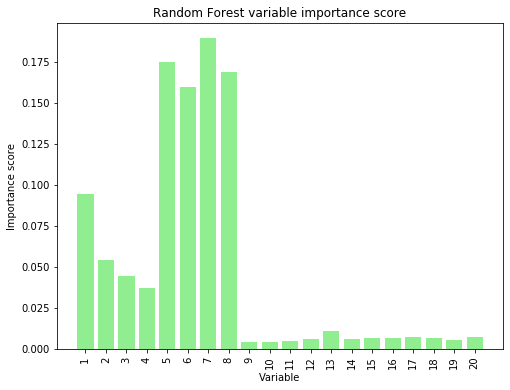

In [39]:
#feature importance
figure = plt.figure(figsize=(8,6))
imp = rf.feature_importances_
plt.bar(range(1,len(imp)+1),imp,color="lightgreen")
plt.xticks(range(1,len(imp)+1),rotation="vertical")#,labels=[col for col in X_train.columns])
plt.ylabel("Importance score")
plt.xlabel("Variable")
plt.title("Random Forest variable importance score")
plt.savefig("importance.png")
plt.show()

In [40]:
X_train.columns

Index(['user_age', 'departure_day', 'departure_hour_sin', 'departure_hour_cos',
       'departure_latitude', 'departure_longitude', 'arrival_latitude',
       'arrival_longitude', 'user_gender_F', 'user_gender_M', 'bike_type_BIKE',
       'bike_type_BIKE,TPV', 'bike_type_ELECTRIC_BIKE', 'departure_weekday_0',
       'departure_weekday_1', 'departure_weekday_2', 'departure_weekday_3',
       'departure_weekday_4', 'departure_weekday_5', 'departure_weekday_6'],
      dtype='object')

### Conclusions

- Female users tend to take slightly longer trips than male users.
- The number of male users is almost three times the number of female users.
- Most people who ride ECOBICI bikes use the service as part of their daily commute.
- ECOBIC travel times can be estimated without much error, from user variables such as age and gender, as well as departure/destination location, departure day/time/day of the week, and bike type. However, the most important variables seem to be age, departure day/hour, and departure/destination location.

### Model retraining and fine-tuning using data from Jan-Jun 2021

For prediction purposes, latest data is gathered and the Random Forest model is fined-tuned and retrained. Data is again gathered from the ECOBICI website, containing bike usage data from January 1st to June 30th 2021. Data comes in a monthly format, hence data tables need to be concatenated.

In [2]:
#additional library
import glob

In [3]:
#read relevant csv file names
file_extension = '.csv'
all_filenames = [i for i in glob.glob(f"2021*{file_extension}")]
#2021 data with datetimes is read, so we have to remove it from the list of filenames
all_filenames.pop(-1)
l = [pd.read_csv(f) for f in all_filenames]

In [4]:
#same column names and add month
col_names = l[0].keys()
for i,s in enumerate(all_filenames):
    l[i].set_axis(col_names,axis=1,inplace=True)
    l[i]["Mes"] = s[5:7]

In [5]:
#Jan 2021 - June 2021 data concatenation
eng_names = ["user_gender","user_age","bike","departure_station","departure_date","departure_time",\
             "arrival_station","arrival_date","arrival_time"]
df_2021 = pd.concat(l,axis=0)
df_2021.set_axis(eng_names + ["month"],axis=1,inplace=True)
df_2021.sort_values("month",inplace=True)
df_2021.reset_index(drop=True,inplace=True)
print(f"Dimensions of concatenated table: Columns = {df_2021.shape[1]}, Rows = {df_2021.shape[0]}")

Dimensions of concatenated table: Columns = 10, Rows = 1990809


Number of records per month


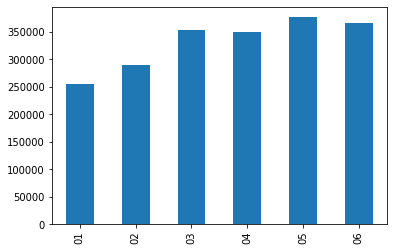

In [6]:
print("Number of records per month")
df_2021["month"].value_counts().sort_index().plot.bar()
plt.show()

After data collection, 190423 observations out of almost two million are found to contain missing data, hance they are  and dropped. 1800386 observations remain.

In [7]:
df_2021.isna().any(axis=0)

user_gender           True
user_age              True
bike                  True
departure_station     True
departure_date        True
departure_time        True
arrival_station      False
arrival_date         False
arrival_time         False
month                False
dtype: bool

In [8]:
df_2021.dropna(inplace=True)
df_2021.reset_index(drop=True,inplace=True)

After removal of missing data, monthly distribution remains virtually unchanged (missing data observations were distributed uniformely across months).

Number of records per month (after dropping missing data)


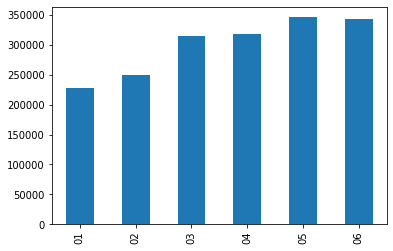

In [9]:
print("Number of records per month (after dropping missing data)")
df_2021["month"].value_counts().sort_index().plot.bar()
plt.show()

After data cleaning, model features are recalculated as done previously for the 2019 data.

In [49]:
#conversion to datetime
#conversion to date and time
df_2021["departure_datetime"] = pd.to_datetime(df_2021["departure_date"] + " " + df_2021["departure_time"],dayfirst = True)
df_2021["arrival_datetime"] = pd.to_datetime(df_2021["arrival_date"] + " " + df_2021["arrival_time"],dayfirst = True)

In [50]:
df_2021.to_csv('2021_data_with_datetimes.csv')

In [10]:
df_2021 = pd.read_csv('2021_data_with_datetimes.csv')

In [11]:
df_2021 = df_2021.iloc[:,1:]

In [12]:
df_2021["departure_datetime"] = pd.to_datetime(df_2021["departure_datetime"])
df_2021["arrival_datetime"] = pd.to_datetime(df_2021["arrival_datetime"])

In [13]:
#trip duration in minutes
df_2021["travel_time"] = (df_2021["arrival_datetime"] - df_2021["departure_datetime"]).dt.total_seconds()/60

In [14]:
#filter out times not in (0,80] mins
df_2021 = df_2021[(df_2021["travel_time"]>0) & (df_2021["travel_time"]<=80)]
df_2021.reset_index(drop=True,inplace=True)

In [15]:
df_2021

,user_gender,user_age,bike,departure_station,departure_date,departure_time,arrival_station,arrival_date,arrival_time,month,departure_datetime,arrival_datetime,travel_time
0,M,32.0,7608.0,18.0,01/01/2021,07:05:04,143,01/01/2021,07:13:25,1,2021-01-01 07:05:04,2021-01-01 07:13:25,8.350000
1,M,43.0,10573.0,217.0,25/01/2021,08:24:35,460,25/01/2021,08:38:22,1,2021-01-25 08:24:35,2021-01-25 08:38:22,13.783333
2,M,43.0,9400.0,443.0,25/01/2021,08:58:05,412,25/01/2021,09:03:56,1,2021-01-25 08:58:05,2021-01-25 09:03:56,5.850000
3,M,40.0,8677.0,52.0,25/01/2021,08:55:16,7,25/01/2021,09:11:34,1,2021-01-25 08:55:16,2021-01-25 09:11:34,16.300000
4,F,28.0,9886.0,42.0,25/01/2021,09:27:44,236,25/01/2021,09:50:30,1,2021-01-25 09:27:44,2021-01-25 09:50:30,22.766667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766011,F,66.0,11949.0,305.0,10/06/2021,18:22:58,312,10/06/2021,18:32:19,6,2021-06-10 18:22:58,2021-06-10 18:32:19,9.350000
1766012,F,33.0,10382.0,23.0,10/06/2021,18:22:52,142,10/06/2021,18:31:53,6,2021-06-10 18:22:52,2021-06-10 18:31:53,9.016667
1766013,F,36.0,7948.0,276.0,09/06/2021,12:41:48,276,09/06/2021,13:12:20,6,2021-06-09 12:41:48,2021-06-09 13:12:20,30.533333
1766014,F,64.0,4242.0,68.0,10/06/2021,18:54:02,37,10/06/2021,18:58:38,6,2021-06-10 18:54:02,2021-06-10 18:58:38,4.600000


In [16]:
#day of the week, day of the month, and hour of the day (including minutes and seconds) are extracted from departure date-time variable
df_2021.loc[:,"departure_weekday"] = df_2021["departure_datetime"].dt.dayofweek
df_2021.loc[:,"departure_day"] = df_2021["departure_datetime"].dt.day
df_2021.loc[:,"departure_hour"] = df_2021["departure_datetime"].dt.hour + (df_2021["departure_datetime"].dt.minute)/60 + (df_2021["departure_datetime"].dt.second)/3600 

In [17]:
#change data types
df_2021 = df_2021.astype(dtype={"user_age":"int8","bike":"int32","departure_station":"int16","arrival_station":"int16","month":"int8","departure_weekday":"int8","departure_day":"int8"})

In [18]:
#merge 2021 data and bike station data
df_2021 = pd.merge(df_2021,df_stations[["id","latitude","longitude","stationType"]],how="left",left_on="departure_station",right_on="id").rename(columns={"latitude":"departure_latitude","longitude":"departure_longitude","stationType":"bike_type"})
del df_2021["id"]
df_2021 = pd.merge(df_2021,df_stations[["id","latitude","longitude"]],how="left",left_on="arrival_station",right_on="id").rename(columns={"latitude":"arrival_latitude","longitude":"arrival_longitude"})
del df_2021["id"]

In [19]:
#check for missing values
df_2021[df_2021[["arrival_latitude","arrival_longitude"]].isna().any(axis=1)]

,user_gender,user_age,bike,departure_station,departure_date,departure_time,arrival_station,arrival_date,arrival_time,month,...,arrival_datetime,travel_time,departure_weekday,departure_day,departure_hour,departure_latitude,departure_longitude,bike_type,arrival_latitude,arrival_longitude


In [20]:
#observations where departure and arrival station is the same are also filtered out
df_2021 = df_2021[df_2021["departure_station"] != df_2021["arrival_station"]]
df_2021.reset_index(drop=True,inplace=True)

After obtaining the data for the model, columns are preprocessed and features are created.

In [21]:
#conversion to categorical type
for s in ["user_gender","departure_station","arrival_station","departure_weekday","bike_type","month"]:
    df_2021[s] = df_2021[s].astype("category")
    
#cyclical variables
period = 24
df_2021["departure_hour_sin"] = np.sin(2*np.pi*df_2021["departure_hour"]/period)
df_2021["departure_hour_cos"] = np.cos(2*np.pi*df_2021["departure_hour"]/period)

In [165]:
#define response vector y and predictor matrix X
y = df_2021["travel_time"]
X = df_2021[["user_gender","user_age","bike_type","month","departure_weekday","departure_day",\
               "departure_hour_sin","departure_hour_cos","departure_latitude","departure_longitude","arrival_latitude","arrival_longitude"]]

In [166]:
#one-hot encoding and train-test data
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [167]:
#scaling training data
#scaler = MinMaxScaler()
#X_train.loc[:,["user_age","departure_day"]] = scaler.fit_transform(X_train[["user_age","departure_day"]])

In [168]:
#scale test data in order to predict on it
#X_test.loc[:,["user_age","departure_day"]] = scaler.transform(X_test[["user_age","departure_day"]])

The model is now trained with the previously used parameters in order to get a preliminary estimator.

In [169]:
rf_2021 = RandomForestRegressor(max_depth = 50,n_estimators=10,random_state = 42,max_features="sqrt",criterion='mse', verbose=1,n_jobs=-1)

In [170]:
rf_2021.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   14.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

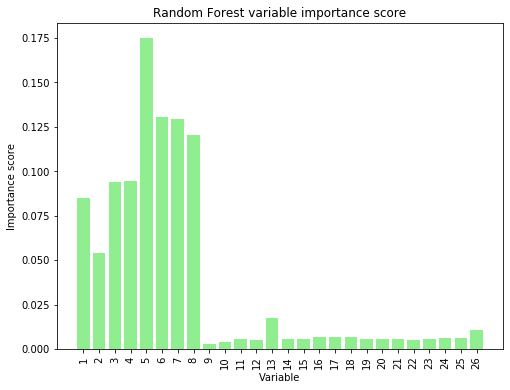

Index(['user_age', 'departure_day', 'departure_hour_sin', 'departure_hour_cos',
       'departure_latitude', 'departure_longitude', 'arrival_latitude',
       'arrival_longitude', 'user_gender_F', 'user_gender_M', 'bike_type_BIKE',
       'bike_type_BIKE,TPV', 'bike_type_ELECTRIC_BIKE', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'departure_weekday_0',
       'departure_weekday_1', 'departure_weekday_2', 'departure_weekday_3',
       'departure_weekday_4', 'departure_weekday_5', 'departure_weekday_6'],
      dtype='object')


In [171]:
#feature importance
figure = plt.figure(figsize=(8,6))
imp = rf_2021.feature_importances_
plt.bar(range(1,len(imp)+1),imp,color="lightgreen")
plt.xticks(range(1,len(imp)+1),rotation="vertical")#,labels=[col for col in X_train.columns])
plt.ylabel("Importance score")
plt.xlabel("Variable")
plt.title("Random Forest variable importance score")
plt.savefig("importance.png")
plt.show()
print(X_train.columns)

In [172]:
#predictions
rf_2021_train_pred = rf_2021.predict(X_train)
rf_2021_test_pred = rf_2021.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.8s finished


In [173]:
#metrics
print("Train RMSE is",np.sqrt(mean_squared_error(y_train,rf_2021_train_pred)))
print("Train MAE is",mean_absolute_error(y_train,rf_2021_train_pred))
print("Train Median AE is",np.median(np.abs(y_train-rf_2021_train_pred)))
print("Test RMSE is",np.sqrt(mean_squared_error(y_test,rf_2021_test_pred)))
print("Test MAE is",mean_absolute_error(y_test,rf_2021_test_pred))
print("Test Median AE is",np.median(np.abs(y_test-rf_2021_test_pred)))

Train RMSE is 3.709781550285589
Train MAE is 2.203226385345731
Train Median AE is 1.1966666666666725
Test RMSE is 8.662747322662442
Test MAE is 5.464217971618266
Test Median AE is 3.450000000000003


Since variable importance suggests a smaller set of variables might be predictive, a smaller set of variables is considered in order to train the model faster and to obtain good enough predictions.

In [174]:
#electric binary variable
df_2021["electric"] = df_2021["bike_type"].apply(lambda s: 1 if s=="ELECTRIC_BIKE" else 0)

In [175]:
#sunday binary variable
df_2021["sunday"] = (df_2021["departure_weekday"] == 6)*1

The model is retrained with the smaller set of variables.

In [176]:
#let's try to retrain the model with less variables and auto setting

#mask to only consider certain observations corresponding to filtered travel times
max_duration = 80
mask = df_2021["travel_time"] <= max_duration

y = df_2021["travel_time"][mask]
X = df_2021[["user_age","user_gender","electric","sunday","departure_day",\
               "departure_hour_sin","departure_hour_cos","departure_latitude","departure_longitude","arrival_latitude","arrival_longitude"]][mask]


X = pd.get_dummies(X)
X.drop(columns = ["user_gender_M","user_gender_F","sunday"],inplace=True)


#X.drop(columns =["user_gender_M","user_gender_F","electric","sunday"],inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#scaler = MinMaxScaler()
#X_train.loc[:,["user_age","departure_day"]] = scaler.fit_transform(X_train[["user_age","departure_day"]])

#X_test.loc[:,["user_age","departure_day"]] = scaler.transform(X_test[["user_age","departure_day"]])

In [177]:
#model
rf_2021_less = RandomForestRegressor(max_depth = 50,n_estimators=10,random_state = 42,max_features="sqrt",criterion='mse', verbose=1,n_jobs=-1)

In [178]:
#fitting the model
rf_2021_less.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

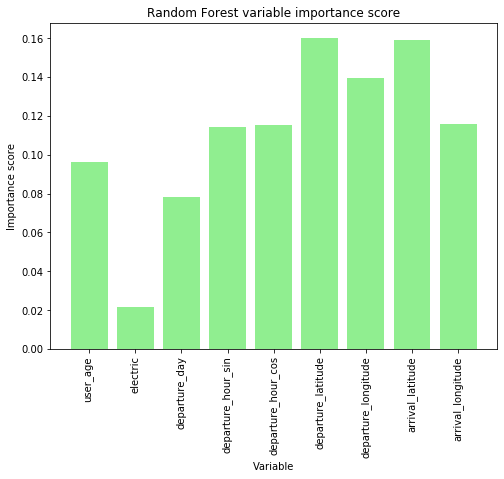

Index(['user_age', 'electric', 'departure_day', 'departure_hour_sin',
       'departure_hour_cos', 'departure_latitude', 'departure_longitude',
       'arrival_latitude', 'arrival_longitude'],
      dtype='object')


In [179]:
#feature importance
figure = plt.figure(figsize=(8,6))
imp = rf_2021_less.feature_importances_
plt.bar(range(1,len(imp)+1),imp,color="lightgreen")
plt.xticks(range(1,len(imp)+1),rotation="vertical",labels=[col for col in X_train.columns])
plt.ylabel("Importance score")
plt.xlabel("Variable")
plt.title("Random Forest variable importance score")
plt.savefig("importance.png")
plt.show()
print(X_train.columns)

In [180]:
#predictions
rf_2021_less_train_pred = rf_2021_less.predict(X_train)
rf_2021_less_test_pred = rf_2021_less.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    2.7s remaining:    1.7s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    1.4s finished


In [181]:
#RMSE
print("Train RMSE is",np.sqrt(mean_squared_error(y_train,rf_2021_less_train_pred)))
print("Train MAE is",mean_absolute_error(y_train,rf_2021_less_train_pred))
print("Train Median AE is",np.median(np.abs(y_train-rf_2021_less_train_pred)))
print("Test RMSE is",np.sqrt(mean_squared_error(y_test,rf_2021_less_test_pred)))
print("Test MAE is",mean_absolute_error(y_test,rf_2021_less_test_pred))
print("Test Median AE is",np.median(np.abs(y_test-rf_2021_less_test_pred)))

Train RMSE is 3.5861992187328786
Train MAE is 2.0269827999864614
Train Median AE is 0.9749999999999996
Test RMSE is 8.426673832204143
Test MAE is 5.10290864641849
Test Median AE is 2.9599999999999973


In [182]:
#viewing test predictions
predictions = pd.DataFrame({'y' : y_test , 'pred' : rf_2021_less_test_pred , 'error' : y_test - rf_2021_less_test_pred, 'abs_error':np.abs(y_test - rf_2021_less_test_pred)} )

In [183]:
predictions

,y,pred,error,abs_error
876681,9.150000,6.891667,2.258333,2.258333
164816,13.266667,13.233333,0.033333,0.033333
205807,7.216667,11.260000,-4.043333,4.043333
1611408,11.283333,12.030000,-0.746667,0.746667
1504280,12.000000,15.693333,-3.693333,3.693333
...,...,...,...,...
1570837,6.966667,5.211667,1.755000,1.755000
229721,39.283333,19.786667,19.496667,19.496667
1168614,10.816667,9.853333,0.963333,0.963333
795843,15.533333,16.608333,-1.075000,1.075000


In [184]:
predictions.describe()

,y,pred,error,abs_error
count,496783.000000,496783.000000,496783.000000,496783.000000
mean,15.196443,15.383837,-0.187395,5.102909
std,11.221640,8.095180,8.424598,6.705911
min,2.000000,2.116667,-57.305000,0.000000
25%,7.233333,9.311667,-4.043333,1.173056
50%,11.850000,13.615000,-1.138333,2.960000
75%,19.766667,19.750000,1.235000,6.318333
max,79.983333,75.041667,75.703333,75.703333


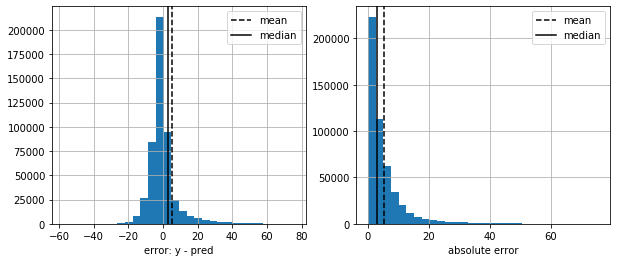

In [185]:
#view residuals
fig,axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist(predictions["error"],bins=30)
axes[0].set_xlabel("error: y - pred")
line_mean = axes[0].axvline(x=predictions.abs_error.mean(),color="black",linestyle="--")
line_median = axes[0].axvline(x=np.median(predictions.abs_error.values),color="black",linestyle="-")
axes[0].legend(handles=[line_mean,line_median],labels=["mean","median"])
axes[0].grid(True)
axes[1].hist(predictions["abs_error"],bins=30)
axes[1].set_xlabel("absolute error")
line_mean = axes[1].axvline(x=predictions.abs_error.mean(),color="black",linestyle="--")
line_median = axes[1].axvline(x=np.median(predictions.abs_error.values),color="black",linestyle="-")
axes[1].legend(handles=[line_mean,line_median],labels=["mean","median"])
axes[1].grid(True)
plt.show()

In [186]:
predictions["trip"] = predictions["y"].apply( lambda y : "exceeded" if y>45 else "normal")

In [188]:
#predictions by type of trip
predictions[["trip","abs_error"]].groupby("trip").describe()

abs_error                                                        \
             count       mean        std       min        25%        50%   
trip                                                                       
exceeded   12662.0  29.497209  14.773517  0.003333  18.377083  29.919167   
normal    484121.0   4.464885   4.946329  0.000000   1.140000   2.850000   

                                
                75%        max  
trip                            
exceeded  39.796667  75.703333  
normal     5.970000  57.305000

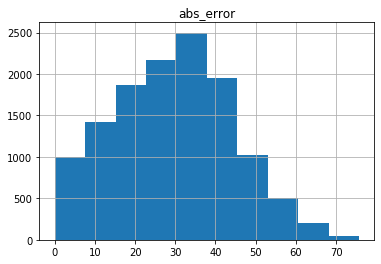

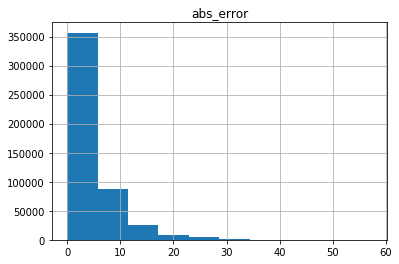

In [189]:
predictions[["trip","abs_error"]].groupby("trip").hist()
plt.show()

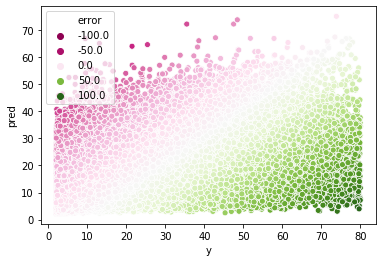

In [195]:
sns.scatterplot(x=predictions["y"],y=predictions["pred"],hue=predictions["error"],palette="PiYG")
plt.show()

In [196]:
predictions["y_binned"] = pd.cut(predictions["y"],bins=np.arange(0,90,10),labels = np.arange(10,90,10) )
predictions["pred_binned"] = pd.cut(predictions["pred"],bins=np.arange(0,90,10), labels = np.arange(10,90,10))

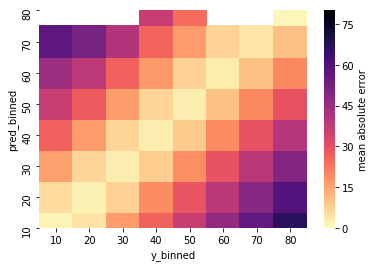

In [197]:
sns.heatmap(pd.pivot_table(data=predictions,values="abs_error",index="pred_binned",columns="y_binned",fill_value=np.nan,aggfunc=np.mean),\
            cmap=plt.get_cmap('magma_r'),cbar_kws={'label': 'mean absolute error'},vmin=0,vmax=80).invert_yaxis()
plt.show()

The model appears to overestimate durations of short trips and to underestimate durations of long trips. Additionally, it predicts with larger absolute errors for longer trips.

Long trips are a rather complex topic. They might occur due to long distances, but they might as well happen due to atypical user behaviours. For this, reason, trips are further filtered out for training and test, and only trips with a duration of one hour or less are considered. 

In [199]:
#mask to only consider certain observations corresponding to filtered travel times
max_duration = 60
mask = df_2021["travel_time"] <= max_duration

y = df_2021["travel_time"][mask]
X = df_2021[["user_age","user_gender","electric","sunday","departure_day",\
               "departure_hour_sin","departure_hour_cos","departure_latitude","departure_longitude","arrival_latitude","arrival_longitude"]][mask]


X = pd.get_dummies(X)
X.drop(columns = ["user_gender_M","user_gender_F","sunday"],inplace=True)


#X.drop(columns =["user_gender_M","user_gender_F","electric","sunday"],inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#scaler = MinMaxScaler()
#X_train.loc[:,["user_age","departure_day"]] = scaler.fit_transform(X_train[["user_age","departure_day"]])

#X_test.loc[:,["user_age","departure_day"]] = scaler.transform(X_test[["user_age","departure_day"]])

In [200]:
#cv grid search for fine-tunning
rand_for = RandomForestRegressor(criterion='mse',max_features='sqrt',n_jobs=-1)

param_grid = {'max_depth' : list(np.arange(20,60,10)), 'n_estimators' : [10] , 'max_features' : [2,3,4,5,6] } #list(np.arange(1,2*np.ceil(np.sqrt(X_train.shape[1]))+1,1))}

grid_search = GridSearchCV( estimator = rand_for, param_grid = param_grid, n_jobs=-1, cv=3 ,verbose=1)

In [201]:
gs = grid_search.fit( X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 13.7min finished


In [234]:
max_depth, max_features, n_estimators = gs.best_params_.values()

In [276]:
model = RandomForestRegressor(n_estimators = n_estimators , max_depth = max_depth  , max_features = max_features, random_state = 42 , criterion = 'mse', n_jobs=-1)

In [277]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [278]:
#predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [279]:
#RMSE
print("Train RMSE is",np.sqrt(mean_squared_error(y_train,train_pred)))
print("Train MAE is",mean_absolute_error(y_train,train_pred))
print("Train Median AE is",np.median(np.abs(y_train-train_pred)))
print("Test RMSE is",np.sqrt(mean_squared_error(y_test,test_pred)))
print("Test MAE is",mean_absolute_error(y_test,test_pred))
print("Test Median AE is",np.median(np.abs(y_test-test_pred)))

Train RMSE is 4.109721087832487
Train MAE is 2.4556388450300464
Train Median AE is 1.445749167703422
Test RMSE is 7.512776204895898
Test MAE is 4.67357437647728
Test Median AE is 2.781124252833692


In [280]:
#viewing test predictions
predictions = pd.DataFrame({'y' : y_test , 'pred' : test_pred , 'error' : y_test - test_pred, 'abs_error':np.abs(y_test - test_pred)} )

In [281]:
predictions

,y,pred,error,abs_error
1396793,11.150000,15.993542,-4.843542,4.843542
1530635,9.500000,20.843333,-11.343333,11.343333
214394,8.250000,8.598922,-0.348922,0.348922
218713,21.133333,25.635185,-4.501852,4.501852
156829,14.516667,15.568955,-1.052288,1.052288
...,...,...,...,...
778062,15.500000,16.529861,-1.029861,1.029861
1362442,13.400000,13.095000,0.305000,0.305000
656075,19.633333,19.470000,0.163333,0.163333
248410,11.950000,11.724178,0.225822,0.225822


In [259]:
predictions.describe()

,y,pred,error,abs_error
count,493785.000000,493785.000000,493785.000000,493785.000000
mean,14.879444,15.024450,-0.145005,4.673574
std,10.486310,7.780516,7.511384,5.882141
min,1.200000,2.067778,-41.717081,0.000000
25%,7.200000,9.049114,-3.628269,1.203207
50%,11.783333,13.007667,-1.212456,2.781124
75%,19.566667,19.220000,1.183907,5.706989
max,60.000000,58.358333,55.638440,55.638440


In [260]:
#predictions by type of trip
predictions["trip"] = predictions["y"].apply( lambda y : "exceeded" if y>45 else "normal")
predictions[["trip","abs_error"]].groupby("trip").describe()

abs_error                                                        \
             count       mean        std       min        25%        50%   
trip                                                                       
exceeded    9802.0  25.896871  12.362863  0.006667  16.320104  26.764676   
normal    483983.0   4.243744   4.785184  0.000000   1.179319   2.707789   

                                
                75%        max  
trip                            
exceeded  35.785720  55.638440  
normal     5.465603  41.717081

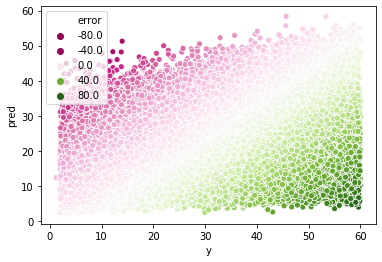

In [263]:
sns.scatterplot(x=predictions["y"],y=predictions["pred"],hue=predictions["error"],palette="PiYG")
plt.show()

### References

- https://www.ecobici.cdmx.gob.mx/en
- https://github.com/dominoFire/ecobici-python/blob/master/ecobici.py
- https://www.ecobici.cdmx.gob.mx/sites/default/files/pdf/user_manual_api_eng_final.pdf
- https://en.wikipedia.org/wiki/Welch%27s_t-test
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- https://towardsdatascience.com/understanding-random-forest-58381e0602d2
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html